<h2>Imports</h2>

In [6]:
import sys
sys.path.append("C:\\Users\\Theo\\Documents\\Unif\\ChimpRec\\Code")

from chimplib.metric import *

test_set = "C:/Users/Theo/Documents/Unif/detection_test_set"
model_path = "C:/Users/Theo/Documents/Unif/Models/body/v8s/weights/best.pt"

<h1>Effective code</h1>

<h3>Ground truth extraction.</h3>

In [7]:
t = 0.6
t_confidence = 0.4
merging_threshold = 0.9

GT = extract_ground_truth()
predictions = predict(model_path, test_set, t_confidence=t_confidence)
#merged_predictions = merge_boxes(predictions, merging_threshold)
#predictions = merged_predictions



image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_11231.png: 384x640 3 Bodys, 117.3ms
Speed: 3.4ms preprocess, 117.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_12495.png: 384x640 3 Bodys, 84.5ms
Speed: 2.8ms preprocess, 84.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_13051.png: 384x640 5 Bodys, 83.2ms
Speed: 2.6ms preprocess, 83.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_13182.png: 384x640 3 Bodys, 86.8ms
Speed: 1.9ms preprocess, 86.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_14122.png: 384x640 4 Body

<h3>Computation of the model performance</h3>

In [8]:
results = extract_metrics(GT, predictions, t=t)

tp, fp, fn = results.values()

print(results)
print(f"precision={tp/(tp+fp)}")
print(f"recall={tp/(tp+fn)}")

{'true_positives': 736, 'false_positives': 136, 'false_negatives': 108}
precision=0.8440366972477065
recall=0.8720379146919431


<h2>Graphs</h2>

In [10]:
"""
Precision and recall as a function of the confidence threshold
"""
iterators = [i/20 for i in range(1, 20, 1)]

data = dict()
n_pred_list = []
for i in iterators:
    pred = predict(model_path, test_set, i)
    results = extract_metrics(GT, pred, t=t)
    tp, fp, fn = results.values()
    if (tp+fp) == 0: precision = 0
    else: precision=tp/(tp+fp)

    if (tp+fn) == 0: recall = 0
    else: recall=tp/(tp+fn)
    data[i] = (precision, recall)
    n_pred = 0
    for values in pred.values():
        n_pred += len(values)
    n_pred_list.append(n_pred)

df = pd.DataFrame.from_dict(data, orient="index", columns=["Precision", "Recall"])

# Set the index name (optional)
df.index.name = "Conf_Threshold"

# Export to CSV
df.to_csv("PR_v8s_custom.csv")


image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_11231.png: 384x640 3 Bodys, 93.9ms
Speed: 2.7ms preprocess, 93.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_12495.png: 384x640 3 Bodys, 93.7ms
Speed: 2.2ms preprocess, 93.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_13051.png: 384x640 5 Bodys, 87.0ms
Speed: 1.6ms preprocess, 87.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_13182.png: 384x640 3 Bodys, 79.8ms
Speed: 2.6ms preprocess, 79.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Theo\Documents\Unif\detection_test_set\images\20241015 - 11h46_frame_14122.png: 384x640 4 Bodys,

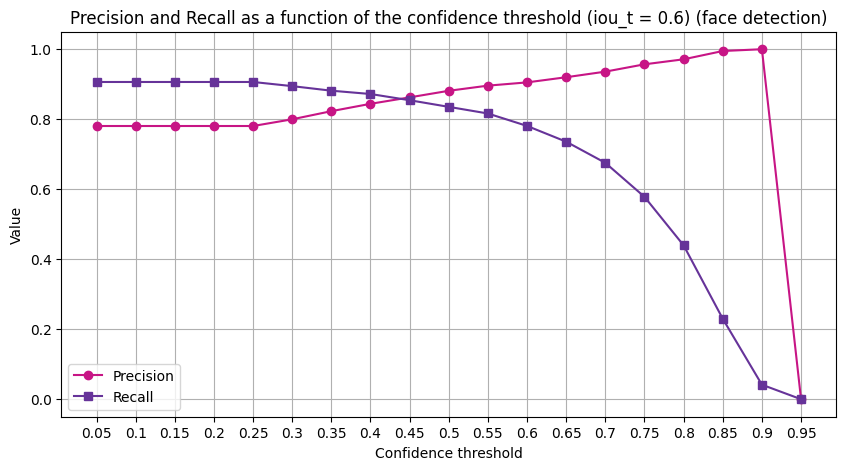

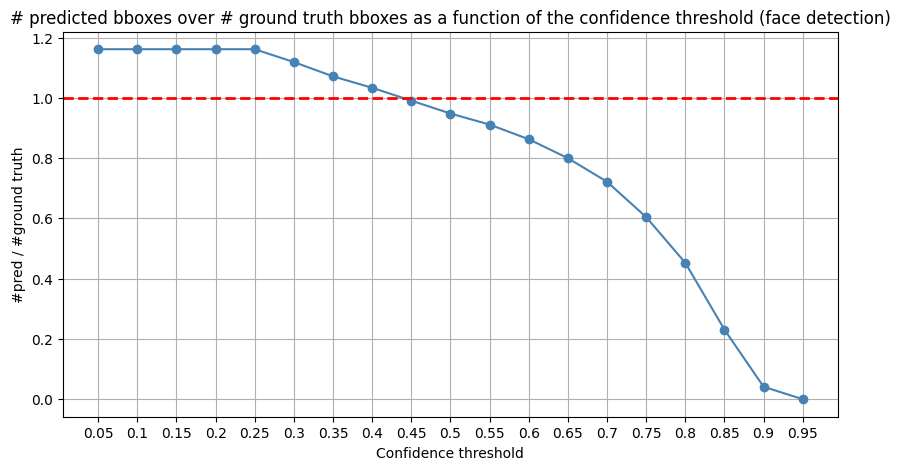

In [12]:
# Sort data by t values
sorted_data = sorted(data.items())  
t_values, pr_recall = zip(*sorted_data)

# Extract precision and recall
precision_values, recall_values = zip(*pr_recall)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(t_values, precision_values, label="Precision", color="mediumvioletred", marker='o', linestyle='-')
plt.plot(t_values, recall_values, label="Recall", color="rebeccapurple", marker='s', linestyle='-')

# Labels and title
plt.xlabel("Confidence threshold")
plt.ylabel("Value")
plt.title(f"Precision and Recall as a function of the confidence threshold (iou_t = {t}) (face detection)")
plt.legend()
plt.grid(True)

# Set x-axis ticks to show all t values
plt.xticks(t_values, labels=[str(t) for t in t_values])  # Ensuring each t is explicitly labeled

# Display the plot
plt.savefig("plots/PR_according_to_CT_body.svg", format="svg")
plt.show()

n_gt = 0
for values in GT.values():
    n_gt += len(values)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(t_values, [i/n_gt for i in n_pred_list], label="ratio n_pred/n_gt", color="steelblue", marker='o', linestyle='-')
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label="y = 1")

# Labels and title
plt.xlabel("Confidence threshold")
plt.ylabel("#pred / #ground truth")
plt.title(f"# predicted bboxes over # ground truth bboxes as a function of the confidence threshold (face detection)")
plt.grid(True)

# Set x-axis ticks to show all t values
plt.xticks(t_values, labels=[str(t) for t in t_values])  # Ensuring each t is explicitly labeled

# Display the plot
plt.savefig("plots/n_pred_over_n_gt_body.svg", format="svg")
plt.show()

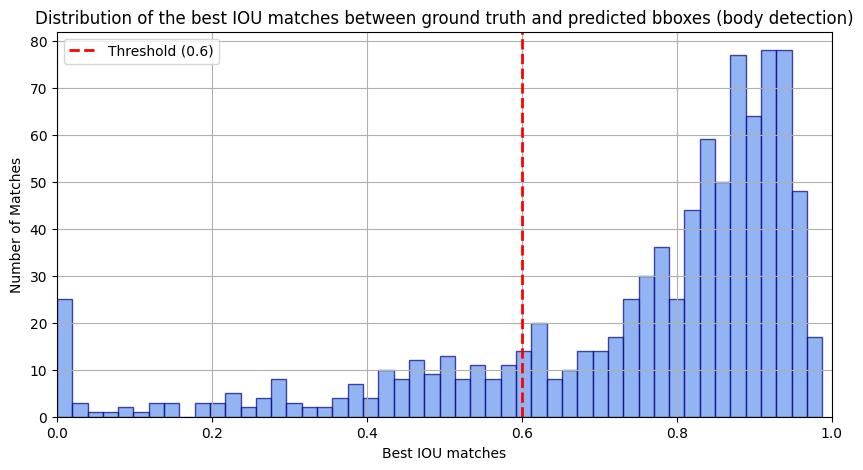

In [ ]:
best_matches = []
# Iterate over all unique image names in ground truths and predictions
for image_name in set(GT.keys()).union(predictions.keys()):
    gt_bboxes = GT.get(image_name, [])  # Retrieve ground truth bboxes (default empty list if missing)
    pred_bboxes = predictions.get(image_name, [])  # Retrieve predicted bboxes (default empty list if missing)
    
    # Iterate over each predicted bounding box
    for pred in pred_bboxes:
        best_iou = 0  # Initialize the best IoU score for the current prediction
        
        # Compare prediction with each ground truth bbox
        for gt in gt_bboxes:
            score = iou(pred, gt)  # Compute IoU
            if score > best_iou:  # Update best match if IoU is higher
                best_iou = score

        best_matches.append(best_iou)

# Plot histogram instead of KDE
plt.figure(figsize=(10, 5))
plt.hist(best_matches, bins=50, color="cornflowerblue", edgecolor="navy", alpha=0.7)

plt.axvline(x=t, color='red', linestyle='--', linewidth=2, label=f"Threshold ({t})")

# Labels and title
plt.xlabel("Best IOU matches")
plt.ylabel("Number of Matches")
plt.title("Distribution of the best IOU matches between ground truth and predicted bboxes (body detection)")
plt.xlim(0, 1)  # Ensuring the range stays between 0 and 1
plt.grid(True)

# Add legend
plt.legend(loc="upper left")

# Save and show the plot
plt.savefig("plots/best_matches_distribution_body.svg", format="svg")
plt.show()


In [ ]:
draw_predictions(predictions, GT, test_set, "visualisation")